# Problem & Data Overview

# Import Libraries

In [ ]:
!pip install ultralytics
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.2 MB/s eta 0:00:00a 0:00:01


In [33]:
!pip install paddleocr
!pip install paddlepaddle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 36.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.0 MB/s eta 0:00:00:00:01
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114248 sha256=99705d21e5dec3604708cee12902446245cf379c22eadb2c54676ca8cd635b9b
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 MB 8.8 MB/s eta 0:00:00:00:0100:01


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import os
import shutil
import yaml
import warnings

import wandb
import random

import cv2
from PIL import Image
from ultralytics import YOLO
import easyocr

# Data Load & Explore

In [16]:
# Paths to your dataset (images and labels)
images_path = '/kaggle/input/egyptian-cars-plates/EALPR Vechicles dataset/Vehicles'
labels_path = '/kaggle/input/egyptian-cars-plates/EALPR Vechicles dataset/Vehicles Labeling'

image_files = sorted(os.listdir(images_path))
label_files = sorted(os.listdir(labels_path))

# Utility Functions

Image Shape: (734, 720, 3)


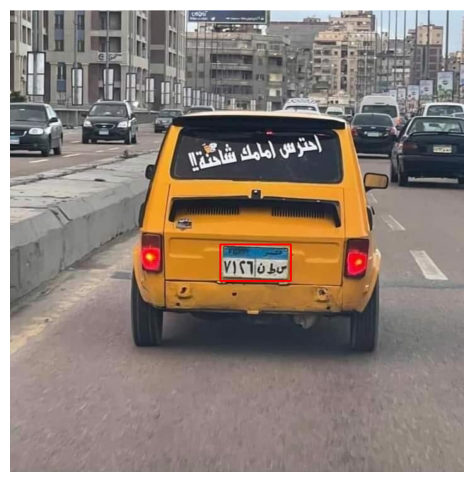

In [17]:
# Function to load bounding boxes from the label file
def load_bounding_boxes(label_file):
    bounding_boxes = []
    with open(label_file, 'r') as file:
        for line in file.readlines():
            values = line.strip().split()
            class_id = int(values[0])  # Class ID (optional if needed)
            x_center = float(values[1])
            y_center = float(values[2])
            width = float(values[3])
            height = float(values[4])
            bounding_boxes.append([x_center, y_center, width, height])
    return bounding_boxes

# Function to draw bounding boxes on the image
def draw_bounding_boxes(image, bounding_boxes):
    h, w = image.shape[:2]
    for bbox in bounding_boxes:
        x_center, y_center, box_width, box_height = bbox
        # Convert YOLO format to corner coordinates
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)
        # Draw the rectangle on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return image

# Function to display image with bounding boxes
def plot_image_with_boxes(image_file, label_file):
    # Load the image
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB for matplotlib
    
    # Print the shape of the image
    print(f"Image Shape: {image.shape}")
    
    # Load bounding boxes from the corresponding label file
    bounding_boxes = load_bounding_boxes(label_file)
    
    # Draw bounding boxes on the image
    image_with_boxes = draw_bounding_boxes(image, bounding_boxes)
    
    # Display the image with bounding boxes
    plt.figure(figsize=(8, 6))
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.show()

# List all images and labels
image_files = sorted(os.listdir(images_path))
label_files = sorted(os.listdir(labels_path))

# Plot a sample image with bounding boxes
sample_index = 0  # Change this to view a different sample
sample_image_file = os.path.join(images_path, image_files[sample_index])
sample_label_file = os.path.join(labels_path, label_files[sample_index])

plot_image_with_boxes(sample_image_file, sample_label_file)

Image Shape: (734, 720, 3)


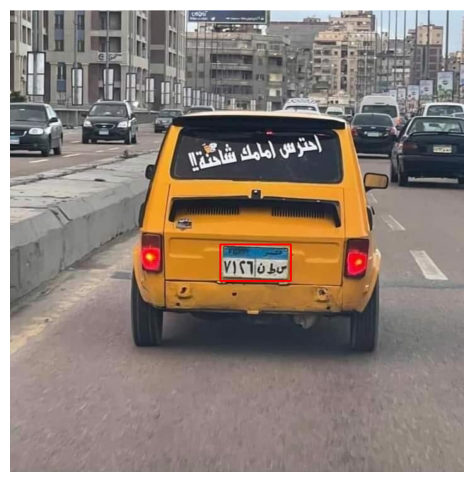

Image Shape: (480, 640, 3)


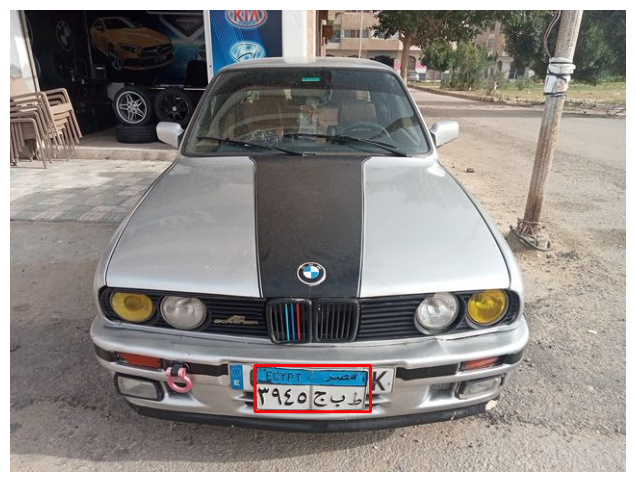

Image Shape: (640, 480, 3)


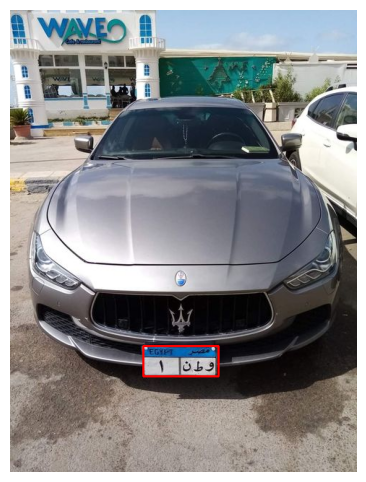

Image Shape: (960, 720, 3)


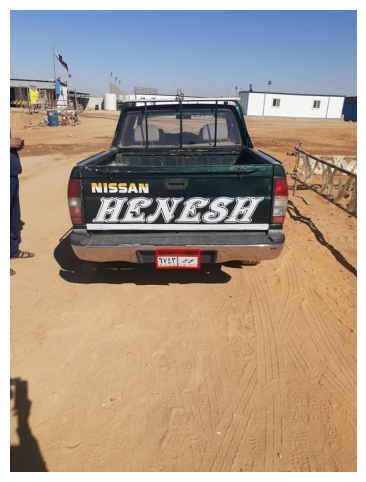

Image Shape: (720, 960, 3)


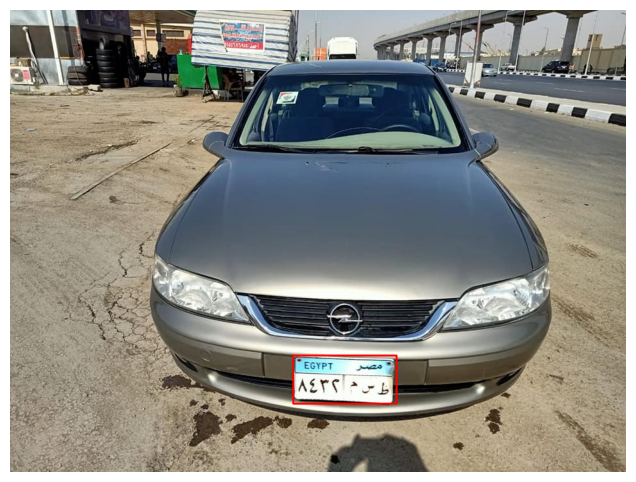

In [18]:
for sample_index in range (5):
    sample_image_file = os.path.join(images_path, image_files[sample_index])
    sample_label_file = os.path.join(labels_path, label_files[sample_index])

    plot_image_with_boxes(sample_image_file, sample_label_file)

# Preprocess Image

In [19]:
# Function to preprocess the input image
def preprocess_image(image_path, target_size=(640, 640)):
    # Read the image
    image = cv2.imread(image_path)
    
    # Resize image to target size (for YOLO or detection model)
    image_resized = cv2.resize(image, target_size)
    
    # Normalize the image (convert to float and scale between 0-1)
    image_normalized = image_resized / 255.0
    
    # Convert image to the format needed by the model (Batch, Height, Width, Channels)
    input_image = np.expand_dims(image_normalized, axis=0)  # Add batch dimension
    
    return input_image, image_resized

# Load bounding boxes from Labels Files

In [20]:
# Function to load bounding boxes from the label file (YOLO format)
def load_bounding_boxes(label_file):
    bounding_boxes = []
    with open(label_file, 'r') as file:
        for line in file.readlines():
            values = line.strip().split()
            class_id = int(values[0])  # Class ID (optional)
            x_center = float(values[1])
            y_center = float(values[2])
            width = float(values[3])
            height = float(values[4])
            bounding_boxes.append([x_center, y_center, width, height])
    return bounding_boxes

In [21]:
# Function to detect and crop the car plate using the bounding boxes
def detect_car_plate(image, bounding_boxes):
    h, w = image.shape[:2]
    for bbox in bounding_boxes:
        x_center, y_center, box_width, box_height = bbox
        # Convert YOLO format to corner coordinates
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)
        cropped_plate = image[y1:y2, x1:x2]  # Crop the detected car plate
        return cropped_plate
    return None

In [22]:
# Function to draw bounding boxes on the image
def draw_bounding_boxes(image, bounding_boxes):
    h, w = image.shape[:2]
    for bbox in bounding_boxes:
        x_center, y_center, box_width, box_height = bbox
        # Convert YOLO format to corner coordinates
        x1 = int((x_center - box_width / 2) * w)
        y1 = int((y_center - box_height / 2) * h)
        x2 = int((x_center + box_width / 2) * w)
        y2 = int((y_center + box_height / 2) * h)
        # Draw the rectangle on the image
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return image

In [23]:
# Function to crop the car plate from the uploaded image
def crop_Plate(yolo_model, img):
    model = YOLO(yolo_model)
    count = 0

    # Perform prediction on the image
    results = model.predict(source=img, conf=0.25)

    # Open the image
    image = Image.open(img)

    for result in results:
        if result.boxes is not None and len(result.boxes) > 0:
            max_width = -1
            selected_box = None

            # Iterate through all detected boxes to find the one with the maximum width
            for box in result.boxes:
                res = box.xyxy[0]  # Get the coordinates of the bounding box
                width = res[2].item() - res[0].item()  # Calculate width (x_max - x_min)

                if width > max_width:
                    max_width = width
                    selected_box = res  # Store the coordinates of the selected box

            if selected_box is not None:
                x_min = selected_box[0].item()
                y_min = selected_box[1].item()
                x_max = selected_box[2].item()
                y_max = selected_box[3].item()

                # Crop the image using the bounding box coordinates
                cropped_image = image.crop((x_min, y_min, x_max, y_max))
                return cropped_image
        else:
            print("No bounding boxes detected.")
    return None



image 1/1 /kaggle/input/egyptian-cars-plates/EALPR Vechicles dataset/Vehicles/0010.jpg: 608x288 1 plate, 32.8ms
Speed: 1.9ms preprocess, 32.8ms inference, 2.7ms postprocess per image at shape (1, 3, 608, 288)


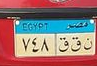

In [24]:
yolo_model = '/kaggle/input/egyptian-plate-cars-recognizer/polo.pt'

resize_image = crop_Plate(yolo_model,
                          "/kaggle/input/egyptian-cars-plates/EALPR Vechicles dataset/Vehicles/0010.jpg")

resize_image


image 1/1 /kaggle/input/egyptian-cars-plates/EALPR Vechicles dataset/Vehicles/0010.jpg: 640x288 1 car_plate, 44.1ms
Speed: 1.4ms preprocess, 44.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


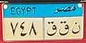

In [25]:
yolo_model = '/kaggle/input/yolos/other/default/1/yolo11m_car_plate_trained.pt'

resize_image1 = crop_Plate(yolo_model,
                          "/kaggle/input/egyptian-cars-plates/EALPR Vechicles dataset/Vehicles/0010.jpg")

resize_image1


image 1/1 /kaggle/input/egyptian-cars-plates/EALPR Vechicles dataset/Vehicles/0010.jpg: 640x288 1 car_plate, 44.7ms
Speed: 1.4ms preprocess, 44.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)


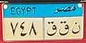

In [26]:
yolo_model = '/kaggle/input/yolos/other/default/1/yolo_car_plate_trained.pt'

resize_image2 = crop_Plate(yolo_model,
                          "/kaggle/input/egyptian-cars-plates/EALPR Vechicles dataset/Vehicles/0010.jpg")

resize_image2

# **OCR**

# OCR DATA


In [1]:
!pip install roboflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.3/85.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 94.3 MB/s eta 0:00:00:00:0100:01


In [2]:
from roboflow import Roboflow

# Initialize Roboflow
rf = Roboflow(api_key="D5lPs61j8et8MnCtxOiO")
project = rf.workspace("egyptian-license-plate").project("egyptian-license-plate-kjqsl")

# Define custom path for download
custom_path = "/kaggle/working/dataset"

# Download dataset in YOLOv11 format to the custom path
dataset = project.version(1).download("yolov11", location=custom_path)

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to /kaggle/working/dataset in yolov11:: 100%|██████████| 28444/28444 [00:03<00:00, 7628.73it/s] 


# Paddle

In [20]:
# Directories
label_dir = '/kaggle/input/egyptian-cars-plates/EALPR Vechicles dataset/Vehicles Labeling'
image_dir = '/kaggle/input/egyptian-cars-plates/EALPR Vechicles dataset/Vehicles'
working_dir = '/kaggle/working/combined_dataset'

# Create a writable directory in /kaggle/working
os.makedirs(working_dir, exist_ok=True)

# List all images and labels
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

# Copy the images and matching label files to the writable directory
for image_file in image_files:
    # Get the base filename without the extension (e.g., image1.jpg -> image1)
    base_name = os.path.splitext(image_file)[0]
    
    # Find the corresponding label file (e.g., image1.txt)
    label_file = f"{base_name}.txt"
    
    if label_file in label_files:
        # Copy the image and label file to the working directory
        shutil.copy(os.path.join(image_dir, image_file), os.path.join(working_dir, image_file))
        shutil.copy(os.path.join(label_dir, label_file), os.path.join(working_dir, label_file))
#         print(f"Copied {image_file} and {label_file} to {working_dir}")
    else:
        print(f"No label found for {image_file}")

print("Image and label files have been copied to the writable directory.")

Image and label files have been copied to the writable directory.


# Create Data for YOLO models¶


In [21]:
# Create the data dictionary
data_dict = {
    'train': "/kaggle/working/combined_dataset",  # Path to the training images
    'val': "/kaggle/working/combined_dataset",    # Use the same for validation; update if you have a separate validation set
    'nc': 1,             # Number of classes (adjust if you have more)
    'names': ['car_plate']  # Class names (adjust as needed)
}

# Specify the path for the YAML file
yaml_file_path = '/kaggle/working/car_plate_data.yaml'

# Write the dictionary to a YAML file
with open(yaml_file_path, 'w') as yaml_file:
    yaml.dump(data_dict, yaml_file)

print(f"YAML file created at: {yaml_file_path}")

YAML file created at: /kaggle/working/car_plate_data.yaml


 # YOLOv11m

In [24]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="yolov11-car-plate",

    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.0002,
    "architecture": "yolov11l.pt",
    "dataset": "car_plate_data.yaml",
    "epochs": 20,
    }
)

model11 = YOLO("yolo11m.pt") 

# simulate training
model11.train(
    data='car_plate_data.yaml',  # Path to your data configuration file
    epochs=20,  # Adjust based on your needs
    batch=8,  # Change based on your GPU memory
    imgsz=640,  # Image size
    cache=True,
    visualize=True,
    augment=True,
    name='yolo11m_car_plate')

Ultralytics 8.3.128 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=car_plate_data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11m_car_plate3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True

train: Scanning /kaggle/working/combined_dataset.cache... 2030 images, 0 backgrounds, 1 corrupt: 100%|██████████| 2031/2031 [00:00<?, ?it/s]

train: /kaggle/working/combined_dataset/2018.jpg: ignoring corrupt image/label: image file is truncated (5 bytes not processed)


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (1.9GB RAM): 100%|██████████| 2030/2030 [00:10<00:00, 196.67it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 815.9±690.4 MB/s, size: 88.9 KB)


val: Scanning /kaggle/working/combined_dataset.cache... 2030 images, 0 backgrounds, 1 corrupt: 100%|██████████| 2031/2031 [00:00<?, ?it/s]

train: /kaggle/working/combined_dataset/2018.jpg: ignoring corrupt image/label: image file is truncated (5 bytes not processed)


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (1.9GB RAM): 100%|██████████| 2030/2030 [00:11<00:00, 180.32it/s]


Plotting labels to runs/detect/yolo11m_car_plate3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11m_car_plate3
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      7.49G     0.6509     0.7672     0.9092         10        640: 100%|██████████| 254/254 [01:20<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:30<00:00,  4.19it/s]


                   all       2030       2083      0.853      0.513      0.569      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.47G      0.691     0.5562     0.9274         14        640: 100%|██████████| 254/254 [01:20<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.59it/s]


                   all       2030       2083      0.964      0.946      0.976      0.799

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.49G     0.6611     0.5131     0.9156         16        640: 100%|██████████| 254/254 [01:19<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.61it/s]

                   all       2030       2083      0.949      0.901      0.942      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.49G     0.6152     0.4623     0.9008          7        640: 100%|██████████| 254/254 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.59it/s]

                   all       2030       2083       0.98      0.977      0.993      0.819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.49G     0.5736     0.4243     0.8916         11        640: 100%|██████████| 254/254 [01:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.61it/s]

                   all       2030       2083      0.975      0.973       0.99      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.49G     0.5299     0.3997     0.8759         11        640: 100%|██████████| 254/254 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.61it/s]

                   all       2030       2083      0.985      0.982      0.994      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.49G     0.5101     0.3648     0.8658          6        640: 100%|██████████| 254/254 [01:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.62it/s]

                   all       2030       2083      0.985      0.984      0.994      0.852



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.49G      0.475     0.3455     0.8546         10        640: 100%|██████████| 254/254 [01:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.61it/s]

                   all       2030       2083      0.985      0.978      0.993      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.49G     0.4604     0.3348     0.8567          8        640: 100%|██████████| 254/254 [01:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.61it/s]

                   all       2030       2083      0.985      0.988      0.993      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.49G     0.4322      0.314     0.8545         14        640: 100%|██████████| 254/254 [01:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.61it/s]

                   all       2030       2083      0.984      0.987      0.994      0.871


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.49G     0.5744     0.3474     0.8621          6        640: 100%|██████████| 254/254 [01:19<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.59it/s]

                   all       2030       2083      0.984      0.964      0.992      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.49G     0.5746     0.3528     0.8669          6        640: 100%|██████████| 254/254 [01:19<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.57it/s]

                   all       2030       2083      0.984      0.985      0.993      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.49G     0.5638     0.3304      0.862          6        640: 100%|██████████| 254/254 [01:19<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.58it/s]

                   all       2030       2083      0.988      0.983      0.994      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.49G     0.5256     0.3167     0.8537          6        640: 100%|██████████| 254/254 [01:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.59it/s]

                   all       2030       2083      0.985      0.992      0.994      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.49G     0.5182     0.2976     0.8499          6        640: 100%|██████████| 254/254 [01:19<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.60it/s]

                   all       2030       2083      0.991      0.993      0.994      0.899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.49G     0.5007     0.2868     0.8433          6        640: 100%|██████████| 254/254 [01:19<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.61it/s]

                   all       2030       2083       0.99      0.991      0.995      0.904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.49G     0.4845     0.2745     0.8396          6        640: 100%|██████████| 254/254 [01:19<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.60it/s]

                   all       2030       2083      0.994      0.992      0.995      0.907



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.49G     0.4753     0.2605     0.8353          6        640: 100%|██████████| 254/254 [01:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.59it/s]

                   all       2030       2083      0.988      0.992      0.995       0.91



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.49G     0.4627     0.2494      0.832          6        640: 100%|██████████| 254/254 [01:19<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.61it/s]

                   all       2030       2083      0.994      0.991      0.994      0.915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.49G       0.45     0.2399     0.8262          7        640: 100%|██████████| 254/254 [01:18<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:27<00:00,  4.60it/s]

                   all       2030       2083      0.993      0.992      0.995      0.919



20 epochs completed in 0.601 hours.
Optimizer stripped from runs/detect/yolo11m_car_plate3/weights/last.pt, 40.5MB
Optimizer stripped from runs/detect/yolo11m_car_plate3/weights/best.pt, 40.5MB

Validating runs/detect/yolo11m_car_plate3/weights/best.pt...
Ultralytics 8.3.128 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 127/127 [00:56<00:00,  2.23it/s]


                   all       2030       2083      0.995       0.99      0.995      0.915
Speed: 0.2ms preprocess, 24.6ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/yolo11m_car_plate3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79535c20a410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [25]:
# # After training, save the model
model11.val()

Ultralytics 8.3.128 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1855.9±405.6 MB/s, size: 75.7 KB)


val: Scanning /kaggle/working/combined_dataset.cache... 2030 images, 0 backgrounds, 1 corrupt: 100%|██████████| 2031/2031 [00:00<?, ?it/s]

train: /kaggle/working/combined_dataset/2018.jpg: ignoring corrupt image/label: image file is truncated (5 bytes not processed)


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (1.9GB RAM): 100%|██████████| 2030/2030 [00:09<00:00, 219.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 254/254 [02:04<00:00,  2.03it/s]


                   all       2030       2083      0.991      0.994      0.995      0.917
Speed: 0.3ms preprocess, 58.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/yolo11m_car_plate32


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79535c240df0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [28]:
model11.save('yolo11m_car_plate_trained.pt')

In [29]:
from IPython.display import FileLink

# Generate the link
FileLink('yolo11m_car_plate_trained.pt')


/kaggle/working/yolo11m_car_plate_trained.pt